In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
from src.utils import get_wandb_summaries
import numpy as np
from src.utils import download_table
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve
import itertools

In [3]:
RUNS = {
    "Same User":"2psz8fbu", #??
    "Autoencoder":"36mkbh97", 
    "No Pretraining":"2911eip8",
    "Daily Features":"2i37p2nw",
}

In [3]:
all_predictions = {}
for k,v in RUNS.items():
    all_predictions[k] = download_table(v,"test_predictions")

In [32]:
def bootstrapped_curve(pred,true,n_iterations=1000,label=None,ax=None,
    curve_gen = roc_curve, ci=True, **kwargs):
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    if not ax:
        fig, ax = plt.subplots()
    
    n = len(pred)
    for i in range(n_iterations):
        inds = np.random.choice(np.arange(n), size=n, replace=True, p=None)
        fpr, tpr, _thresholds = curve_gen(true[inds],pred[inds])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        # interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
   

    mean_tpr = np.mean(tprs, axis=0)
    # mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    ax.plot(
        mean_fpr,
        mean_tpr,
        lw=2,
        alpha=0.8,
        label=label,
        **kwargs,
    )
    if ci:
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + 2 * std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - 2 * std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            alpha=0.2,
            **kwargs
        )
    

def bootstrapped_roc_curve(pred,true,**kwargs):
    bootstrapped_curve(pred,true,curve_gen = roc_curve, **kwargs)

def bootstrapped_pr_curve(pred,true, **kwargs):
    bootstrapped_curve(pred,true, curve_gen = precision_recall_curve, **kwargs)




In [12]:
    
def plot_curves(runs,figsize=(7,4),legend_args={},roc=True,pr=True):   
    fig = plt.figure(figsize=figsize)
    if roc and pr:
        ax0 = plt.subplot(1, 2, 1,aspect="equal")
        ax1 = plt.subplot(1, 2, 2,aspect="equal")

    palette = itertools.cycle(sns.color_palette())
    predictions = {}
    for k,v in runs.items():
        predictions[k] = download_table(v,"test_predictions")
        
    for name,df in predictions.items():
        color=next(palette)
        
        bootstrapped_roc_curve(df["pred"],df["label"],label=name,ax=ax0,
            color=color,n_iterations=100)
        ax0.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)
        ax0.set(
            xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title="Receiver Operating\nCharacteristic (± 2 std)",
            xlabel="False Positive Rate",
            ylabel="True Positive Rate"
        )

        bootstrapped_pr_curve(df["pred"],df["label"],label=name,ax=ax1,
            color=color,n_iterations=100)
        
        ax1.set(
            xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title="Precision Recall (± 2 std)",
            xlabel="Recall",
            ylabel="Precision"
        )

    handles, labels = ax0.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(.5, -0.1), loc='lower center', ncol=4, **legend_args)
    plt.tight_layout()
    return fig

In [ ]:
    with plt.style.context('/homes/gws/mikeam/seattleflustudy/src/visualization/stylesheets/paper.mplstyle'):
        fig = plt.figure(figsize=(7,4))
        ax0 = plt.subplot(1, 2, 1,aspect="equal")
        ax1 = plt.subplot(1, 2, 2,aspect="equal")

        palette = itertools.cycle(sns.color_palette())

        for name,df in all_predictions.items():
            color=next(palette)
            bootstrapped_roc_curve(df["pred"],df["label"],label=name,ax=ax0,
                color=color,n_iterations=100)
            ax0.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)
            ax0.set(
                xlim=[-0.05, 1.05],
                ylim=[-0.05, 1.05],
                title="Receiver Operating\nCharacteristic (± 2 std)",
                xlabel="False Positive Rate",
                ylabel="True Positive Rate"
            )

            bootstrapped_pr_curve(df["pred"],df["label"],label=name,ax=ax1,
                color=color,n_iterations=100)
            
            ax1.set(
                xlim=[-0.05, 1.05],
                ylim=[-0.05, 1.05],
                title="Precision Recall (± 2 std)",
                xlabel="Recall",
                ylabel="Precision"
            )

        handles, labels = ax0.get_legend_handles_labels()
        fig.legend(handles, labels, bbox_to_anchor=(.5, -0.1), loc='lower center', ncol=4, title="Pretraining Method")
        plt.tight_layout()


In [15]:
FLU_RUNS = {
    "Our Model":"z0nbehr0", 
    "XGBoost":"7r8nxjo5", 
    # "CNN":"ko9zy18b"
}

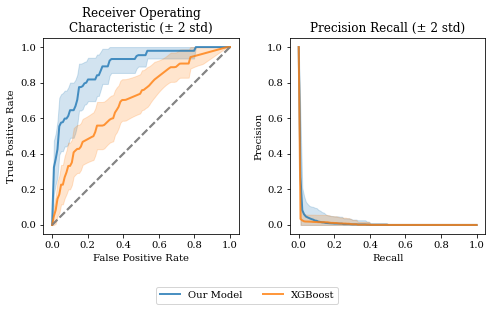

In [16]:
with plt.style.context('/homes/gws/mikeam/seattleflustudy/src/visualization/stylesheets/paper.mplstyle'):
    plot_curves(FLU_RUNS)

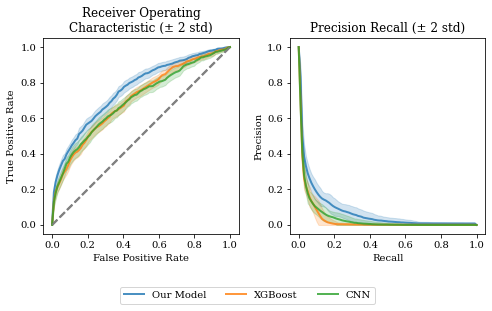

In [14]:
fatigue_runs = {
    "Our Model":"23qp4fss", 
    "XGBoost":"19h7xs81", 
    "CNN":"9kq7490z"
}
with plt.style.context('/homes/gws/mikeam/seattleflustudy/src/visualization/stylesheets/paper.mplstyle'):
    plot_curves(fatigue_runs)

In [17]:
flu_predictions = {}
for k,v in FLU_RUNS.items():
    flu_predictions[k] = download_table(v,"test_predictions")

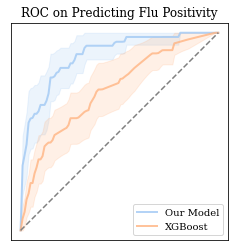

In [31]:
with plt.style.context('/homes/gws/mikeam/seattleflustudy/src/visualization/stylesheets/paper.mplstyle'):
    ax0 = plt.subplot(1, 1, 1,aspect="equal")
    palette = itertools.cycle(sns.color_palette("pastel"))
    for name,df in flu_predictions.items():
        color=next(palette)
        bootstrapped_roc_curve(df["pred"],df["label"],label=name,n_iterations=100,color=color, ax=ax0)
    ax0.set_yticklabels([])
    ax0.set_xticklabels([])
    ax0.set_xticks([])
    ax0.set_yticks([])
    plt.plot([0,1],[0,1], linestyle = "--", color="grey")
    plt.title("ROC on Predicting Flu Positivity")
    plt.legend()
plt.savefig("reports/kdd2022/teaser_roc_with_ci.svg")


In [ ]:
FLU_RUNS_ALL = {
    "Our Model":"z0nbehr0", 
    "XGBoost":"7r8nxjo5", 
    # "CNN":"ko9zy18b"
}